<p style="font-size:40px">Machine Learning Classification Part 2</p> <br>


<p style="font-family:'Courier New'">Pada jupyter notebook ini, akan diawali dengan prosedur standar yaitu prerprocessing. Kemudian saya akan melakukan hyperparameter tuning dengan bantuan RandomizedSearchCV. Pada modeling bagian pertama, telah ditunjukkan bahwa model-model kebanyakan mengalami overfitting. Yang artinya model tidak menggeneralisasi dengan baik pada data baru. Itu kenapa, mencegah overfitting menjadi tujuan objektif di notebook ini.

><p style="font-family:'Courier New'">Tujuan objektif dari jupyter notebook ini adalah bagaimana melakukan hyperparameter tuning untuk mencegah model mengalami overfitting. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, confusion_matrix, classification_report, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, binarize
from sklearn.preprocessing import binarize, OneHotEncoder
from jcopml.tuning.space import Real, Integer
from sklearn.compose import ColumnTransformer
from yellowbrick.model_selection import LearningCurve, ValidationCurve

from jcopml.tuning import random_search_params as rsp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from mlxtend.plotting import plot_learning_curves

import warnings
warnings.filterwarnings("ignore")

# Dataset Splitting

In [2]:
bank = pd.read_csv('bank_clean.csv')

X = bank.drop('y', axis = 1)
y = bank['y'].map({'no' : 0, 'yes' : 1})

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

# Preprocessing

In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age']),
        ('cat', categorical_transformer, ['month','pdays'])])

# Evaluation Metrics

In [5]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred, average = 'macro'))
    prec.append(precision_score(y_test, y_pred, average = 'macro'))
    recall.append(recall_score(y_test, y_pred, average = 'macro'))
    matthews.append(matthews_corrcoef(y_test, y_pred))

# With Original Datasets

In [45]:
metricTuned_Original = pd.DataFrame(index = ['Logistic Regression', 
                                             'Random Forest Classifier (experiment 1)', 'Random Forest Classifier (experiment 2)',
                                             'XGBoost Classifier (experiment 1)', 'XGBoost Classifier (experiment 2)']) 
f1 = []
prec = []
recall = []
matthews = []

## Model Selection

### Logisitic Regression

In [14]:
logreg_params = {
    'logreg__fit_intercept': [True, False],
    'logreg__C': Real(low=-2, high=2, prior='log-uniform')
}

In [15]:
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg', LogisticRegression(random_state = 101))])

logreg_random = RandomizedSearchCV(estimator=logreg,param_distributions=logreg_params, scoring='f1_macro', cv = 5
                                  ,random_state = 101)

logreg_random.fit(X_train, y_train)
print(logreg_random.best_params_)
print(logreg_random.score(X_train, y_train), logreg_random.score(X_test, y_test))

{'logreg__C': 64.67514810219672, 'logreg__fit_intercept': False}
0.6421254849812693 0.6390086381213801


##### Learning Curves

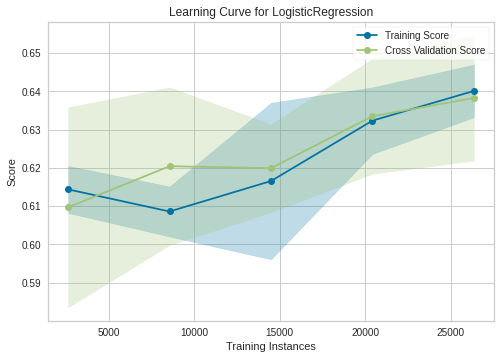

In [9]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    logreg_random.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

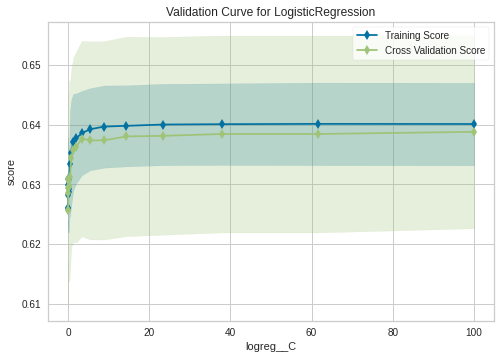

In [16]:
viz = ValidationCurve(
    logreg_random.best_estimator_, param_name="logreg__C",
    param_range= np.logspace(-2, 2, 20), cv = 5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

> <p style="font-family:'Courier New'"> Dari <i>validation curve</i> di atas terlihat bahwa perubahan C (di atas sekitar 1) tidak mempengaruhi model. Itu alasan kenapa, model sebelum di tuning dan setelah di tuning punya bentuk grafik yang sama. 

In [46]:
logreg_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg', LogisticRegression(random_state = 101, fit_intercept = False, C = 64.68))])

logreg_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [47]:
y_pred_logreg = logreg_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_logreg)

In [48]:
confusion_matrix(y_test, y_pred_logreg)

array([[7167,  112],
       [ 744,  215]])

In [49]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7279
           1       0.66      0.22      0.33       959

    accuracy                           0.90      8238
   macro avg       0.78      0.60      0.64      8238
weighted avg       0.88      0.90      0.87      8238



###### Catatan untuk Random Forest dan XGBoost:

<p style="font-family:'Courier New'">Untuk Random Forest Classifier dan XGBoost Classifier pada original dataset dan SMOTE, terdapat dua eksperimen. Dimana hyperparameter-hyperparameter yang diberi dari RandomizedSearchCV ternyata masih membuat model mengalami overfitting. 
    
<p style="font-family:'Courier New'">Jadi saya rangkum: Untuk experiment 1 saya melakukan tuning berdasarkan dari validation curve (Mencoba satu-satu dari titik-titik kemungkinan dari validation curve) dan RandomizedSearchCV yang didapat. Sedangkan untuk experiment 2 saya melakukannya secara manual tuning tetap berdasarkan dari tuning RandomizedSearchCV. Titik berat dari experimen 2 adalah saya melakukannya secara trial and error sampai mendapatkan kurva yang saya inginkan. 

### Random Forest Classifier

In [17]:
rfc_params = {
    'rfc__n_estimators': Integer(low=150, high=250),
    'rfc__max_depth': Integer(low=10, high=40),
    'rfc__max_features': Real(low=0.1, high=1, prior='uniform'),
    'rfc__min_samples_leaf': Integer(low=1, high=18)
}

In [18]:
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101))])

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rfc_params, 
                                scoring='f1_macro', cv = 5,random_state = 101)

rfc_random.fit(X_train, y_train)
print(rfc_random.best_params_)
print(rfc_random.score(X_train, y_train), rfc_random.score(X_test, y_test))

{'rfc__max_depth': 29, 'rfc__max_features': 0.30911829563328463, 'rfc__min_samples_leaf': 3, 'rfc__n_estimators': 194}
0.7438361619888914 0.6610857599472955


> Score di atas menunjukkan bahwa sepertinya model masih mengalami overfitting. Namun untuk memastikannya, saya akan mem-plot <i>learning curve</i>-nya. 

###### Learning Curve

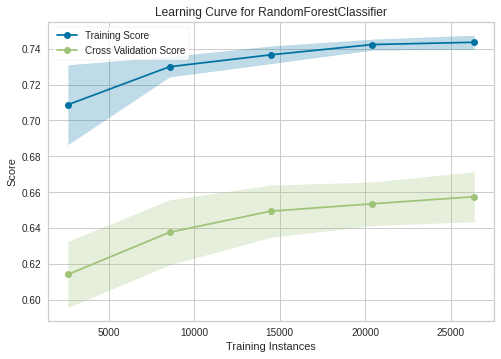

In [19]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_random.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

###### Validation Curve

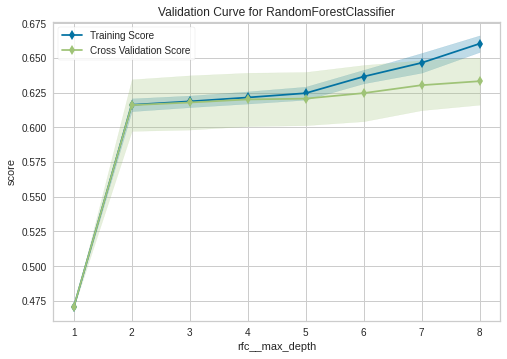

In [20]:
viz = ValidationCurve(
    rfc_random.best_estimator_, param_name="rfc__max_depth",
    param_range=np.arange(1, 9), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

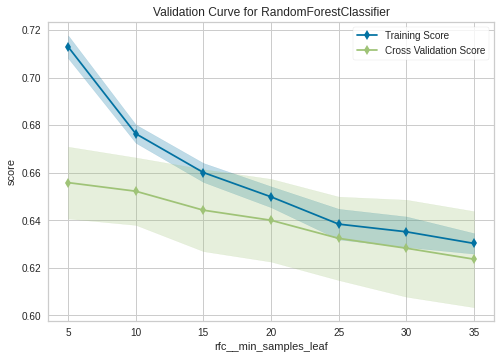

In [23]:
viz = ValidationCurve(
    rfc_random.best_estimator_, param_name="rfc__min_samples_leaf",
    param_range=np.arange(0, 40, 5), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

##### Experiment 1

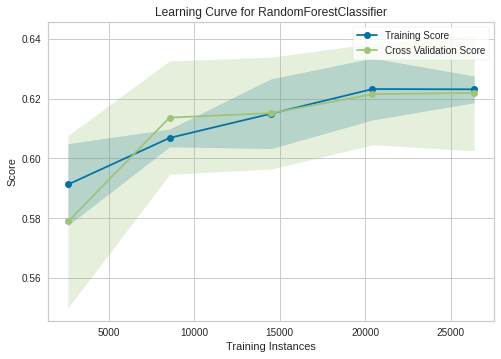

In [28]:
rfc_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 194,
                                                   max_features = 0.3, min_samples_leaf = 20, 
                                                     max_depth = 5))])

rfc_tuned.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    rfc_tuned, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [50]:
rfc_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 194,
                                                   max_features = 0.3, min_samples_leaf = 20, 
                                                     max_depth = 5))])

rfc_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [51]:
y_pred_rfc = rfc_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_rfc)

In [52]:
confusion_matrix(y_test, y_pred_rfc)

array([[7214,   65],
       [ 783,  176]])

In [53]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7279
           1       0.73      0.18      0.29       959

    accuracy                           0.90      8238
   macro avg       0.82      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



##### Experiment 2 (Manual Tuning)

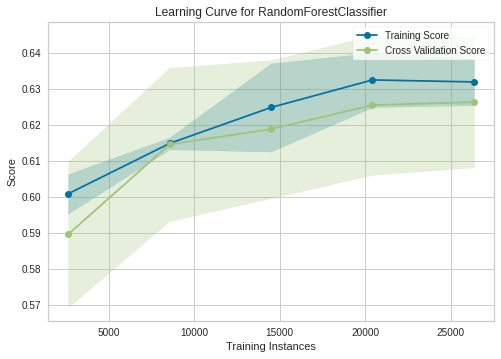

In [15]:
rfc_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.5, min_samples_leaf = 13, 
                                                     max_depth = 5))])

rfc_tuned.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    rfc_tuned, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [54]:
rfc_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.5, min_samples_leaf = 13, 
                                                     max_depth = 5))])

rfc_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [55]:
y_pred_rfc = rfc_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_rfc)

In [56]:
confusion_matrix(y_test, y_pred_rfc)

array([[7210,   69],
       [ 777,  182]])

In [57]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7279
           1       0.73      0.19      0.30       959

    accuracy                           0.90      8238
   macro avg       0.81      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



### XGB Classifier

In [43]:
xgb_params = {
    'xgb__max_depth': Integer(low=2, high=10),
    'xgb__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'xgb__n_estimators': Integer(low=150, high= 250),
    'xgb__subsample': Real(low=0.4, high=0.8, prior='uniform'),
    'xgb__gamma': Integer(low=1, high=9),
    'xgb__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'xgb__reg_alpha': Real(low=-2, high=1, prior='log-uniform'),
    'xgb__reg_lambda': Real(low=-2, high=1, prior='log-uniform')
}

In [45]:
xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101))])

xgb_random = RandomizedSearchCV(estimator=xgb,param_distributions=xgb_params, scoring='f1_macro', cv = 5
                                  ,random_state = 101)

xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)
print(xgb_random.score(X_train, y_train), rfc_random.score(X_test, y_test))

{'xgb__colsample_bytree': 0.5647587649322016, 'xgb__gamma': 2, 'xgb__learning_rate': 0.8042086054140226, 'xgb__max_depth': 9, 'xgb__n_estimators': 225, 'xgb__reg_alpha': 1.1371845354380694, 'xgb__reg_lambda': 3.1746115201900342, 'xgb__subsample': 0.5227864878688951}
0.7197484564094547 0.6610857599472955


##### Learning Curves

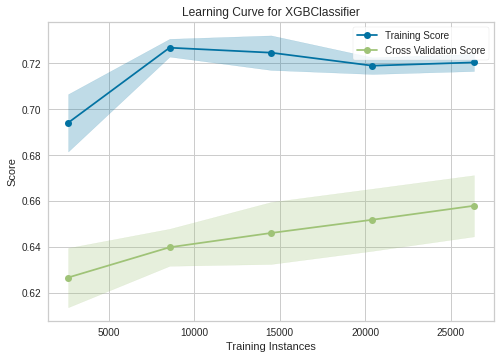

In [47]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb_random.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

    Learning Curve pada XGBClassifier juga masih menunjukkan overfitting. 

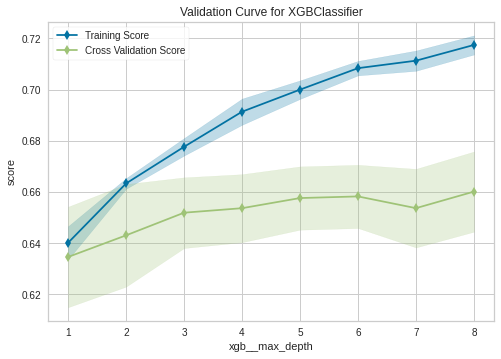

In [48]:
viz = ValidationCurve(
    xgb_random.best_estimator_, param_name="xgb__max_depth",
    param_range=np.arange(1, 9), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

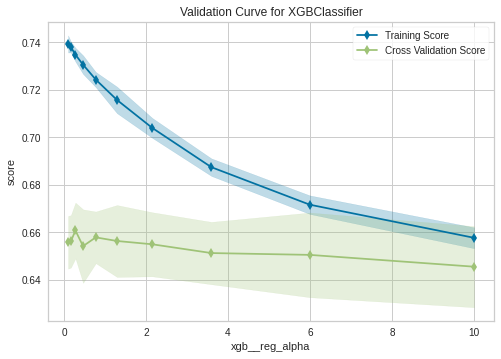

In [51]:
viz = ValidationCurve(
    xgb_random.best_estimator_, param_name="xgb__reg_alpha",
    param_range=np.logspace(-1, 1, 10), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

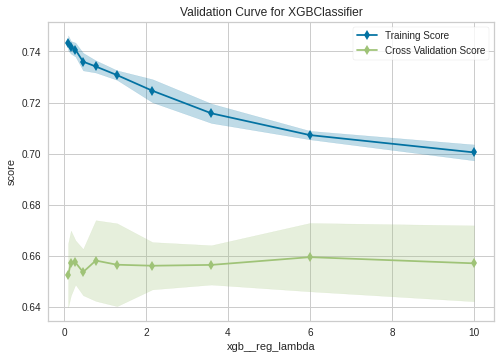

In [53]:
viz = ValidationCurve(
    xgb_random.best_estimator_, param_name="xgb__reg_lambda",
    param_range=np.logspace(-1, 1, 10), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

###### Experiment 1

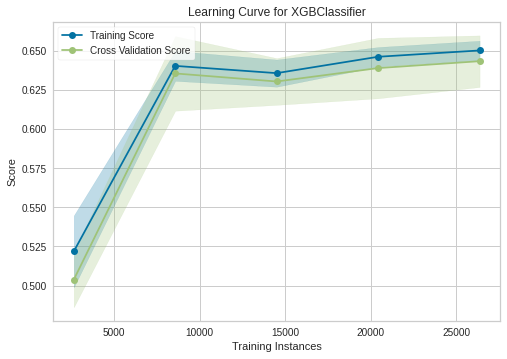

In [19]:
xgb_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.8, 
                                            max_depth = 6, n_estimators = 175,
                                            reg_alpha = 10, reg_lambda = 6,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    xgb_tuned, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [58]:
xgb_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.8, 
                                            max_depth = 6, n_estimators = 175,
                                            reg_alpha = 10, reg_lambda = 6,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [59]:
y_pred_xgb = xgb_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb)

In [61]:
confusion_matrix(y_test, y_pred_xgb)

array([[7174,  105],
       [ 731,  228]])

In [62]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7279
           1       0.68      0.24      0.35       959

    accuracy                           0.90      8238
   macro avg       0.80      0.61      0.65      8238
weighted avg       0.88      0.90      0.88      8238



##### Experiment 2 (Manual tuned)

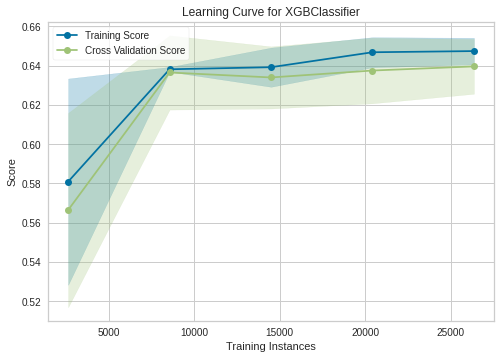

In [23]:
xgb_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.8, 
                                            max_depth = 7, n_estimators = 175,
                                            reg_alpha = 8, reg_lambda = 8,
                                            subsample = 0.7, colsample_bytree = 0.7))])

xgb_tuned.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    xgb_tuned, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [63]:
xgb_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.8, 
                                            max_depth = 7, n_estimators = 175,
                                            reg_alpha = 8, reg_lambda = 8,
                                            subsample = 0.7, colsample_bytree = 0.7))])

xgb_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [64]:
y_pred_xgb = xgb_tuned.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb)

In [65]:
confusion_matrix(y_test, y_pred_xgb)

array([[7174,  105],
       [ 746,  213]])

In [66]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7279
           1       0.67      0.22      0.33       959

    accuracy                           0.90      8238
   macro avg       0.79      0.60      0.64      8238
weighted avg       0.88      0.90      0.87      8238



## Overall Evaluation

In [67]:
metricTuned_Original['Macro F1-Score'] = f1
metricTuned_Original['Macro Recall'] = recall
metricTuned_Original['Macro Precision'] = prec
metricTuned_Original['MCC'] = matthews

In [68]:
metricTuned_Original

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression,0.639009,0.604403,0.781723,0.343002
Random Forest Classifier (experiment 1),0.618911,0.587297,0.816189,0.332280
Random Forest Classifier (experiment 2),0.622705,0.590151,0.813908,0.336447
XGBoost Classifier (experiment 1),0.648942,0.611661,0.796106,0.363668
XGBoost Classifier (experiment 2),0.638802,0.603841,0.787810,0.345753


# With Smote

In [72]:
sm = SMOTE(random_state=101, sampling_strategy=1.0)

In [69]:
metricTuned_smote = pd.DataFrame(index = ['Logistic Regression (with SMOTE)', 
                                             'Random Forest Classifier (experiment 1 with SMOTE)', 'Random Forest Classifier (experiment 2 with SMOTE)',
                                             'XGBoost Classifier (experiment 1 with SMOTE)', 'XGBoost Classifier (experiment 2 with SMOTE)']) 
f1 = []
prec = []
recall = []
matthews = []

## Model Selection

### Logistic Regression

> Karena dari hasil Default dengan menggunakan SMOTE didapatkannya model yang underfitting. Maka strategi yang saya gunakan, saya mengecilkan parameter regularisasinya yaitu C.

In [25]:
logreg_params_smote = {
    'logreg__fit_intercept': [True, False],
    'logreg__C': Real(low=-2, high=2, prior='log-uniform')
}

In [27]:
logreg_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('logreg', LogisticRegression(random_state = 101))])

logreg_random_smote = RandomizedSearchCV(estimator=logreg_smote,param_distributions=logreg_params_smote, scoring='f1_macro', cv = 5
                                  ,random_state = 101)

logreg_random_smote.fit(X_train, y_train)
print(logreg_random_smote.best_params_)
print(logreg_random_smote.score(X_train, y_train), logreg_random_smote.score(X_test, y_test))

{'logreg__C': 1.163039623196803, 'logreg__fit_intercept': False}
0.67768280129441 0.6833997196413722


##### Learning Curve

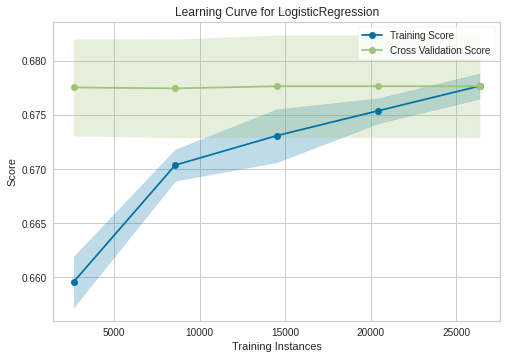

In [28]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    logreg_random_smote.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

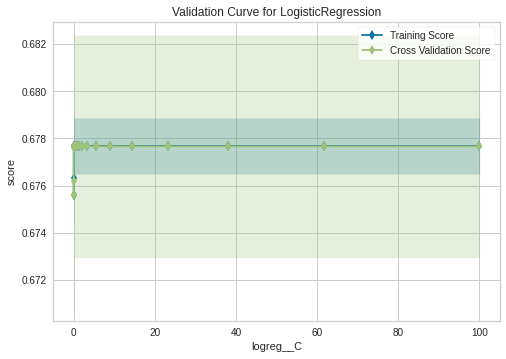

In [29]:
viz = ValidationCurve(
    logreg_random_smote.best_estimator_, param_name="logreg__C",
    param_range= np.logspace(-2, 2, 20), cv = 5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

In [73]:
logreg_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('logreg', LogisticRegression(random_state = 101, C = 1.16, fit_intercept = False))])

logreg_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [74]:
y_pred_test_logreg_smote = logreg_tuned_smote.predict(X_test)
evaluationMetrics(y_test, y_pred_test_logreg_smote)

In [75]:
confusion_matrix(y_test, y_pred_test_logreg_smote)

array([[6295,  984],
       [ 372,  587]])

In [76]:
print(classification_report(y_test, y_pred_test_logreg_smote))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7279
           1       0.37      0.61      0.46       959

    accuracy                           0.84      8238
   macro avg       0.66      0.74      0.68      8238
weighted avg       0.88      0.84      0.85      8238



### Random Forest Classifier

In [33]:
rfc_params_smote = {
    'rfc__n_estimators': Integer(low=150, high=250),
    'rfc__max_depth': Integer(low=10, high=40),
    'rfc__max_features': Real(low=0.1, high=1, prior='uniform'),
    'rfc__min_samples_leaf': Integer(low=1, high=18)
}

In [34]:
rfc_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('rfc', RandomForestClassifier(random_state = 101))])

rfc_random_smote = RandomizedSearchCV(estimator = rfc_smote, param_distributions = rfc_params_smote, 
                                scoring='f1_macro', cv = 5,random_state = 101)

rfc_random_smote.fit(X_train, y_train)
print(rfc_random_smote.best_params_)
print(rfc_random_smote.score(X_train, y_train), rfc_random_smote.score(X_test, y_test))

{'rfc__max_depth': 13, 'rfc__max_features': 0.6209105819278753, 'rfc__min_samples_leaf': 8, 'rfc__n_estimators': 160}
0.7185697118093477 0.7026969730593786


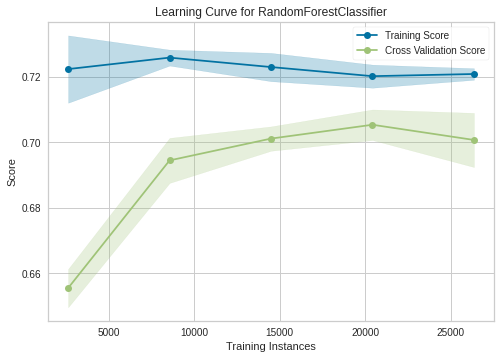

In [35]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_random_smote.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

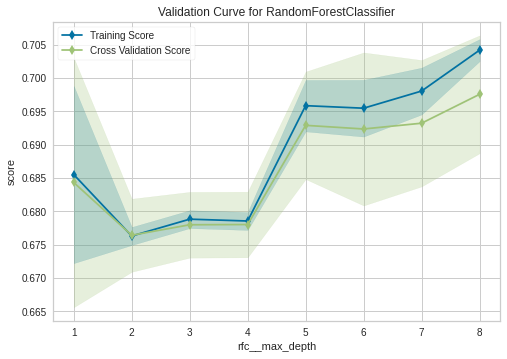

In [36]:
viz = ValidationCurve(
    rfc_random_smote.best_estimator_, param_name="rfc__max_depth",
    param_range=np.arange(1, 9), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

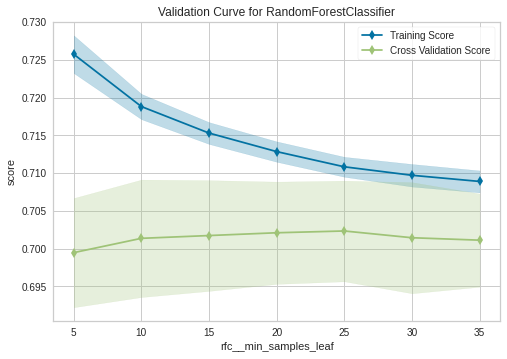

In [38]:
viz = ValidationCurve(
    rfc_random_smote.best_estimator_, param_name="rfc__min_samples_leaf",
    param_range=np.arange(0, 40, 5), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

#### Experiment 1

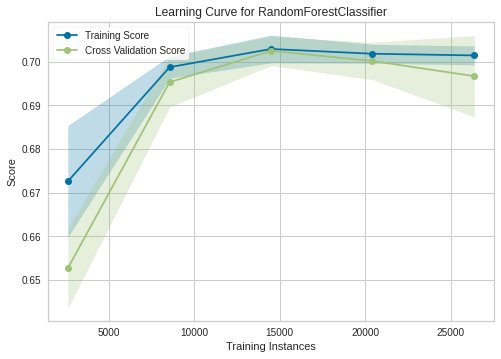

In [22]:
rfc_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 160,
                                                   max_features = 0.62, min_samples_leaf = 25, 
                                                     max_depth = 8))])

rfc_tuned_smote.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    rfc_tuned_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [77]:
rfc_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 160,
                                                   max_features = 0.62, min_samples_leaf = 25, 
                                                     max_depth = 8))])

rfc_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [78]:
y_pred_rfc_smote = rfc_tuned_smote.predict(X_test)
evaluationMetrics(y_test, y_pred_rfc_smote)

In [79]:
confusion_matrix(y_test, y_pred_rfc_smote)

array([[6432,  847],
       [ 377,  582]])

In [80]:
print(classification_report(y_test, y_pred_rfc_smote))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      7279
           1       0.41      0.61      0.49       959

    accuracy                           0.85      8238
   macro avg       0.68      0.75      0.70      8238
weighted avg       0.88      0.85      0.86      8238



#### Experiment 2 (manual tune )

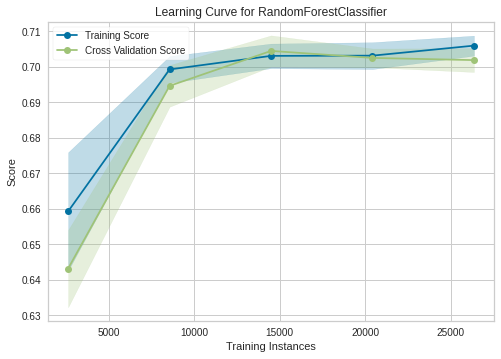

In [40]:
rfc_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.8, min_samples_leaf = 35, 
                                                     max_depth = 8))])

rfc_tuned_smote.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    rfc_tuned_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [81]:
rfc_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('rfc', RandomForestClassifier(random_state = 101, n_estimators = 300,
                                                   max_features = 0.8, min_samples_leaf = 35, 
                                                     max_depth = 8))])

rfc_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [82]:
y_pred_test_rfc_smote = rfc_tuned_smote.predict(X_test)
evaluationMetrics(y_test, y_pred_test_rfc_smote)

In [83]:
confusion_matrix(y_test, y_pred_test_rfc_smote)

array([[6474,  805],
       [ 383,  576]])

In [84]:
print(classification_report(y_test, y_pred_test_rfc_smote))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7279
           1       0.42      0.60      0.49       959

    accuracy                           0.86      8238
   macro avg       0.68      0.75      0.70      8238
weighted avg       0.88      0.86      0.87      8238



### XGB Classifier

In [5]:
xgb_params_smote = {
    'xgb__max_depth': Integer(low=2, high=10),
    'xgb__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'xgb__n_estimators': Integer(low=150, high= 250),
    'xgb__subsample': Real(low=0.4, high=0.8, prior='uniform'),
    'xgb__gamma': Integer(low=1, high=9),
    'xgb__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'xgb__reg_alpha': Real(low=-2, high=1, prior='log-uniform'),
    'xgb__reg_lambda': Real(low=-2, high=1, prior='log-uniform')
}

In [9]:
xgb_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm',sm),
                      ('xgb', XGBClassifier(random_state = 101))])

xgb_random_smote = RandomizedSearchCV(estimator=xgb_smote,param_distributions=xgb_params_smote, scoring='f1_macro', cv = 5
                                  ,random_state = 101)

xgb_random_smote.fit(X_train, y_train)
print(xgb_random_smote.best_params_)
print(xgb_random_smote.score(X_train, y_train), xgb_random_smote.score(X_test, y_test))

{'xgb__colsample_bytree': 0.6231317905724443, 'xgb__gamma': 3, 'xgb__learning_rate': 0.16110048377545383, 'xgb__max_depth': 5, 'xgb__n_estimators': 160, 'xgb__reg_alpha': 1.1374150916607335, 'xgb__reg_lambda': 0.35776876564423377, 'xgb__subsample': 0.4193938149705603}
0.7145820181262563 0.7066024186537668


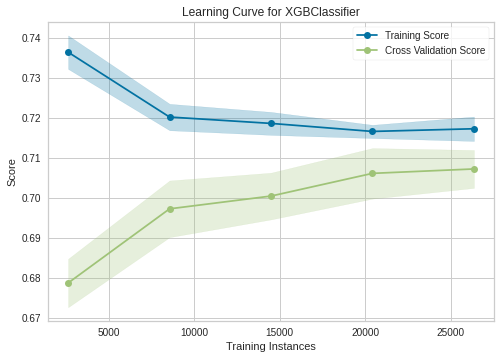

In [10]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb_random_smote.best_estimator_, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

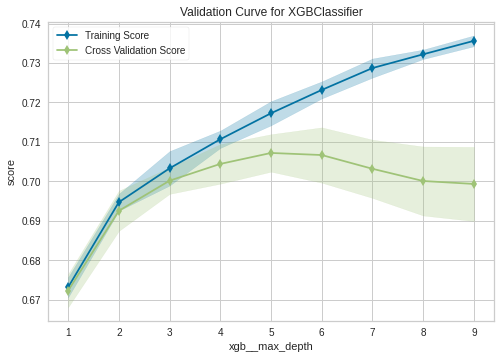

In [12]:
viz = ValidationCurve(
    xgb_random_smote.best_estimator_, param_name="xgb__max_depth",
    param_range=np.arange(1, 10), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

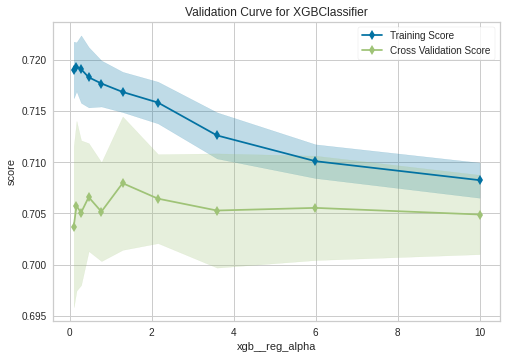

In [14]:
viz = ValidationCurve(
    xgb_random_smote.best_estimator_, param_name="xgb__reg_alpha",
    param_range=np.logspace(-1, 1, 10), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

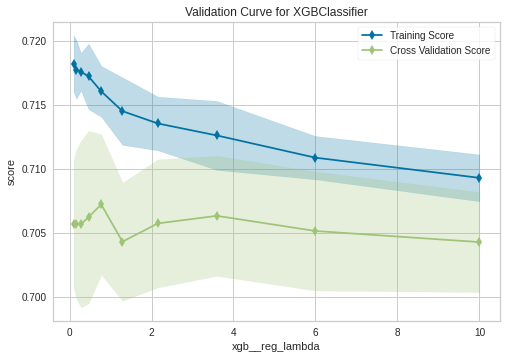

In [15]:
viz = ValidationCurve(
    xgb_random_smote.best_estimator_, param_name="xgb__reg_lambda",
    param_range=np.logspace(-1, 1, 10), cv=5, scoring="f1_macro"
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()

#### Experiment 1 

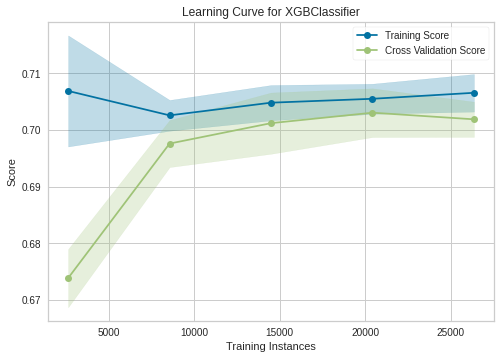

In [23]:
xgb_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.1, 
                                            max_depth = 5, n_estimators = 160,
                                            reg_alpha = 1.5, reg_lambda = 3.5,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned_smote.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    xgb_tuned_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> Model masih mengalami overfitting. Namun tidak seburuk sebelumnya. 

In [85]:
xgb_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 3, learning_rate = 0.1, 
                                            max_depth = 5, n_estimators = 160,
                                            reg_alpha = 1.5, reg_lambda = 3.5,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [86]:
y_pred_xgb_smote = xgb_tuned_smote.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb_smote)

In [87]:
confusion_matrix(y_test, y_pred_xgb_smote)

array([[6465,  814],
       [ 386,  573]])

In [88]:
print(classification_report(y_test, y_pred_xgb_smote))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7279
           1       0.41      0.60      0.49       959

    accuracy                           0.85      8238
   macro avg       0.68      0.74      0.70      8238
weighted avg       0.88      0.85      0.87      8238



#### Experiment 2 (manual tuning)

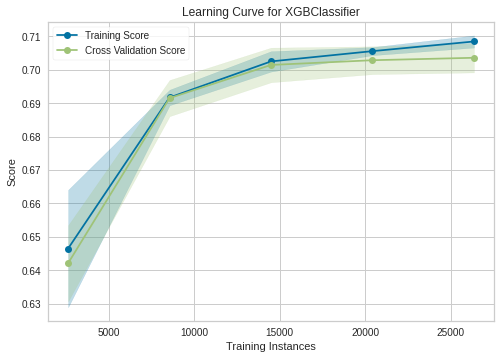

In [55]:
xgb_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 4, learning_rate = 0.1, 
                                            max_depth = 9, n_estimators = 200,
                                            reg_alpha = 10, reg_lambda = 10,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned_smote.fit(X_train, y_train)

sizes = np.linspace(0.3, 1, 10)
visualizer = LearningCurve(
    xgb_tuned_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

In [89]:
xgb_tuned_smote = Pipeline(steps=[('preprocessor', preprocessor), ('sm', sm),
                      ('xgb', XGBClassifier(random_state = 101, gamma = 4, learning_rate = 0.1, 
                                            max_depth = 9, n_estimators = 200,
                                            reg_alpha = 10, reg_lambda = 10,
                                            subsample = 0.5, colsample_bytree = 0.7))])

xgb_tuned_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [90]:
y_pred_xgb_smote = xgb_tuned_smote.predict(X_test)
evaluationMetrics(y_test, y_pred_xgb_smote)

In [91]:
confusion_matrix(y_test, y_pred_xgb_smote)

array([[6477,  802],
       [ 381,  578]])

In [92]:
print(classification_report(y_test, y_pred_xgb_smote))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      7279
           1       0.42      0.60      0.49       959

    accuracy                           0.86      8238
   macro avg       0.68      0.75      0.71      8238
weighted avg       0.88      0.86      0.87      8238



## Evaluation

In [93]:
metricTuned_smote['Macro F1-Score'] = f1
metricTuned_smote['Macro Recall'] = recall
metricTuned_smote['Macro Precision'] = prec
metricTuned_smote['MCC'] = matthews

In [94]:
metricTuned_smote

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with SMOTE),0.683400,0.738456,0.658925,0.389341
Random Forest Classifier (experiment 1 with SMOTE),0.700277,0.745260,0.675955,0.415474
Random Forest Classifier (experiment 2 with SMOTE),0.704133,0.745017,0.680617,0.420733
XGBoost Classifier (experiment 1 with SMOTE),0.701783,0.742834,0.678390,0.416265
XGBoost Classifier (experiment 2 with SMOTE),0.705274,0.746266,0.681643,0.423000


# Overall

In [96]:
metricTuned_Original

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression,0.639009,0.604403,0.781723,0.343002
Random Forest Classifier (experiment 1),0.618911,0.587297,0.816189,0.332280
Random Forest Classifier (experiment 2),0.622705,0.590151,0.813908,0.336447
XGBoost Classifier (experiment 1),0.648942,0.611661,0.796106,0.363668
XGBoost Classifier (experiment 2),0.638802,0.603841,0.787810,0.345753


In [95]:
metricTuned_smote

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with SMOTE),0.683400,0.738456,0.658925,0.389341
Random Forest Classifier (experiment 1 with SMOTE),0.700277,0.745260,0.675955,0.415474
Random Forest Classifier (experiment 2 with SMOTE),0.704133,0.745017,0.680617,0.420733
XGBoost Classifier (experiment 1 with SMOTE),0.701783,0.742834,0.678390,0.416265
XGBoost Classifier (experiment 2 with SMOTE),0.705274,0.746266,0.681643,0.423000
